<a href="https://colab.research.google.com/github/fisich/isit_labs/blob/master/13-16/13_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
import keras

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Setting seed for reproducability
np.random.seed(0)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, SimpleRNN, GRU
%matplotlib inline

## **Получение данных**

In [161]:
# Data ingestion - reading the datasets from Azure blob 
!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt 
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt 

--2021-12-14 12:17:14--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.38, 13.107.213.38, 2620:1ec:bdf::38, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.38|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘PM_train.txt.3’

PM_train.txt.3      100%[===================>]   3.35M  --.-KB/s    in 0.09s   

2021-12-14 12:17:14 (36.2 MB/s) - ‘PM_train.txt.3’ saved [3515356/3515356]

--2021-12-14 12:17:14--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.38, 13.107.213.38, 2620:1ec:bdf::38, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.38|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: ‘PM_test.txt.3’

PM_te

In [162]:
# Чтение обучающих данных
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [163]:
# Чтение тестовых данных
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [164]:
# Чтение истинных данных
# (ground truth - реальная информация, получаемая прямым наблюдением)
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [165]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## **Предобработка данных**
Первый шаг - сгенерировать метки для данных обучения

In [166]:
# Маркировка данных - создание столбца RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [167]:
# Генерация столбца меток для обучающих данных
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [168]:
# MinMax нормализация
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


Далее подготавливаем тестовые данные. Сначала мы нормализуем тестовые данные, используя параметры из нормализации MinMax, примененной к обучающим данным.

In [169]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [170]:
# Генерация столбца max для тестовых данных
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [171]:
# Генерация столбца RUL для тестовых данных
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [172]:
# Генерация столбцов меток w0 и w1 для тестовых данных
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


## **Моделированиие обучения**

In [173]:
# Окно размером 50 циклов
sequence_length = 50

Вариант 13 по списку

In [174]:
# Подготовка данных для визуализации
# Для двигателя с ID 13 окно в 50 циклов до достижения момента отказа
engine_id13 = test_df[test_df['id'] == 13]
engine_id13_50cycleWindow = engine_id13[engine_id13['RUL'] <= engine_id13['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id13_50cycleWindow1 = engine_id13_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id13_50cycleWindow2 = engine_id13_50cycleWindow[cols2]

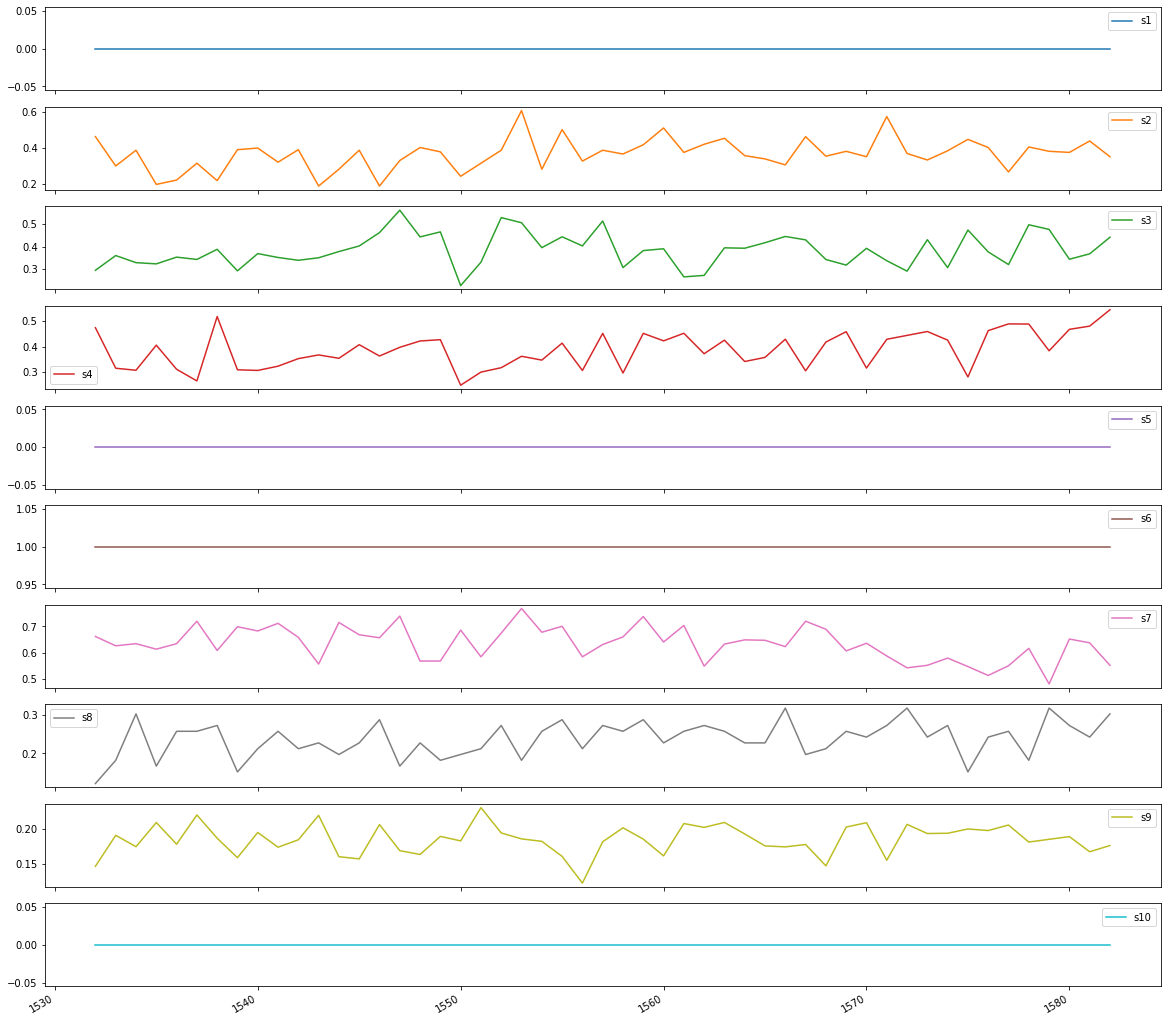

In [175]:
# Построение данных датчиков 1-10 двигателя 13
ax1 = engine_id13_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

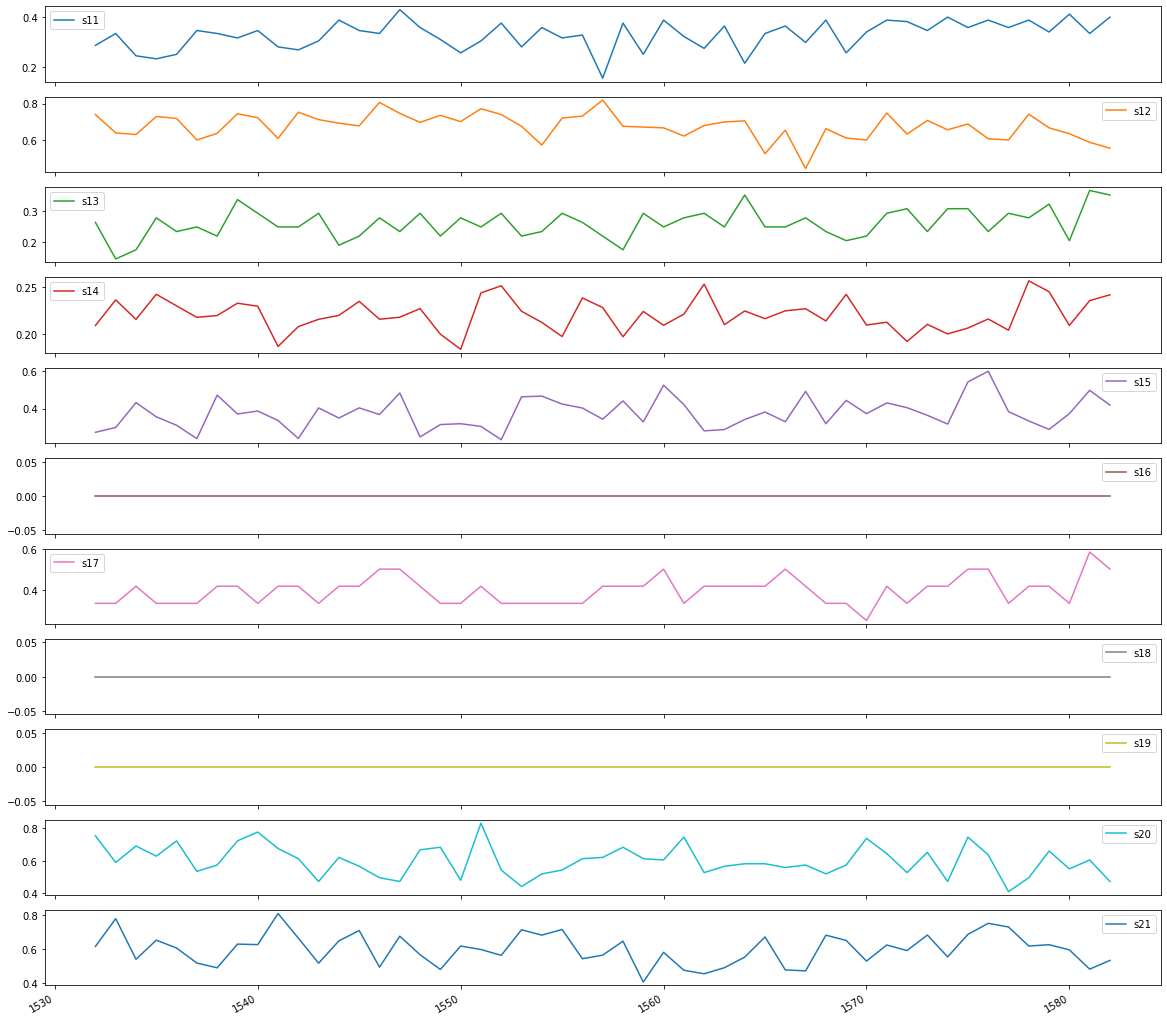

In [176]:
# Построение данных датчиков 11-21 двигателя 13
ax2 = engine_id13_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

Слои Keras LSTM ожидают ввода в виде массива из трех измерений (samples, time steps, features), где образцы - это количество обучающих последовательностей, временные шаги - это окно ретроспективного обзора или длина последовательности, а признаки - это количество признаков каждой последовательности на каждом временном шаге.

In [177]:
# Функция преобразования features в (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [178]:
# Выбор столбца признаков 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [179]:
# Генератор последовательности
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [180]:
# Непосредственно генерация и преобразование в массив numpy
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [181]:
# функция генерации меток
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [182]:
# Генерация меток
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

# **LSTM сеть**

In [183]:
# Построение нейросети, добавление слоев
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### **назначение используемых методов и параметров**

Sequential() - класс, создает группу слоев, где каждый слой имеет ровно один входной тензор и один выходной тензор.

add() - добавляет слой к объявленной последовательности

LSTM() - Слой долгой краткосрочной памяти - Hochreiter 1997. Хорошо приспособлена к обучению на задачах классификации, обработки и прогнозирования временных рядов в случаях, когда важные события разделены временными лагами с неопределённой продолжительностью и границами.
Параметры:


*   units - Положительное целое число, размерность выходного пространства.
*   input_shape - размер входных данных слоя нейронной сети
*   return_sequences - Возвращать ли последний вывод в выходной последовательности. True для того, чтобы слой возвращал последовательность. По умолчанию: False.

Dropout() - метод прореживания/исключения. Слой, который случайным образом отбрасывает входные значения, устанавливая их значение в 0 с частотой rate = 0.2. Метод применяется для решения проблемы переобучения

Dense() - полносвязный слой.
Параметры:


*   units - Положительное целое число, размерность выходного пространства.
*   activation - функция активации слоя. Сигмоидальная функция возвращает значения [0,1] (Для малых значений (<-5) сигмоид возвращает значение, близкое к нулю, а для больших значений (> 5) результат функции приближается к 1.)

compile() - Настраивает модель для обучения. Параметры:


*   loss - функция потерь, в данном случае binary_crossentropy, которая используется в задачах двоичной классификации.
*   optimizer - оптимизатор, adam - это адаптивный алгоритм оптимизации скорости обучения, разработанный специально для обучения глубоких нейронных сетей.
*   metrics - набор функций, используемых для оценки производительности модели. В данном случае используется только метод accuracy

summary() - функция, отображающая структуру сети


In [184]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 100)           50400     
                                                                 
 dropout_12 (Dropout)        (None, 50, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


Определение числа параметров Param в каждом слое:

---
Для слоев LSTM кол-во параметров расчиывается по формуле:

$params = 4 * ((input\_size + 1) * output\_size + output\_size^2)$

Согласно этому для lstm получаем:
$params = 4 * ((25 + 1) * 100 + 100 ^ 2) = 50400$

Для lstm_1 размер входных данных 100, а выходных 50:
$params = 4 * ((100 + 1) * 50 + 50 ^ 2) = 30200$

Слои Dropout, как было сказано раннее, не обучают модель, поэтому число параметров для этих слоев всегда равно 0.

Для слоев Dense кол-во параметров:

$params = output\_size*(input\_size + 1)$

Согласно этому для dense: $params = 1 * (50 + 1) = 51$

# **Обучение на CPU**

In [185]:
lstm_cpu_time = time.time()
# Обучение нейросети
fit_history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
lstm_cpu_time = time.time() - lstm_cpu_time

Epoch 1/10
75/75 [==============================] - 8s 50ms/step - loss: 0.2697 - accuracy: 0.8889 - val_loss: 0.1113 - val_accuracy: 0.9476
Epoch 2/10
75/75 [==============================] - 3s 37ms/step - loss: 0.1003 - accuracy: 0.9607 - val_loss: 0.0529 - val_accuracy: 0.9770


In [186]:
lstm_cpu_time
#37.31594181060791

10.54189944267273

# **Обучение на GPU**

In [187]:
lstm_gpu_time = time.time()
# Обучение нейросети
fit_history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
lstm_gpu_time = time.time() - lstm_gpu_time

Epoch 1/10
75/75 [==============================] - 3s 38ms/step - loss: 0.0970 - accuracy: 0.9605 - val_loss: 0.0622 - val_accuracy: 0.9783
Epoch 2/10
75/75 [==============================] - 3s 37ms/step - loss: 0.0716 - accuracy: 0.9703 - val_loss: 0.0605 - val_accuracy: 0.9770


In [188]:
lstm_gpu_time

5.669240236282349

# Графическая зависимость для Loss и Accuracy на Train и Validation подвыборках

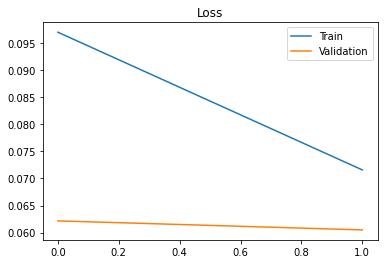

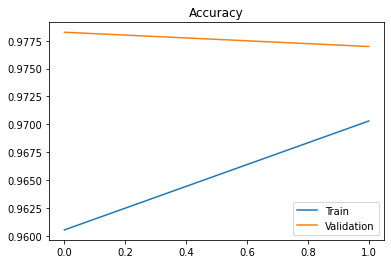

In [189]:
plt.title('Loss')
plt.plot(fit_history.history['loss'], label='Train')
plt.plot(fit_history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(fit_history.history['accuracy'], label='Train')
plt.plot(fit_history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

### **назначение используемых методов и параметров**
fit() - функция обучения. Параметры:

*   x - входные данные, в данном случае это список характеристик, получаемых с сенсоров
*   y - целевые данные. Как и входные данные x, это может быть либо массив (ы) Numpy, либо тензор (ы) TensorFlow.
*   epochs - Целое число. Количество эпох для обучения модели.
*   batch_size - Количество образцов, которые распространяться по сети при обновлении градиента.
*   validation_split - Часть обучающих данных, которая будет использоваться в качестве данных проверки. В диапазоне (0, 1)
*   verbose - режим детализации (0 = ничего, 1 = индикатор выполнения, 2 = одна строка на эпоху), 'auto' в большинстве случаев по умолчанию равен 1.
*   callbacks - Список обратных вызовов во время обучения, в данном случае используется EarlyStopping (ранняя остановка)

EarlyStopping() - функция, прекращающая обучение, когда отслеживаемый показатель перестает улучшаться. Параметры:

*   monitor - величина, значение которой требуется отслеживать
*   min_delta - минимальное изменение отслеживаемой величины, которое квалифицируется как улучшение
*   patience - количество эпох, в которых не наблюдается улучшение, после достижения которого обучение будет остановлено
*   verbose - режим детализации, 0 = ничего
*   mode - В режиме auto обучение остановится, когда величина перестает расти или уменьшаться, также есть режимы min и max. В данном случае значение var_loss должно уменьшаться


In [190]:
# Показатель точности обучения
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 1s 14ms/step - loss: 0.0727 - accuracy: 0.9691
Accurracy: 0.9690998792648315


In [191]:
# Получение предсказания и вычисление матрицы путаницы
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 2s 11ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12379,   152],
       [  331,  2769]])

In [192]:
# Вычисление precision и recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9479630263608353 
 recall =  0.8932258064516129


#### **теперь рассмотрим работу с тестовыми данными.**

In [193]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [194]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [195]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [196]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [197]:
# Точность тестовых данных
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0844 - accuracy: 0.9677 - 46ms/epoch - 15ms/step
Accurracy: 0.9677419066429138


In [198]:
# Получение предсказания и вычисление матрицы путаницы
y_pred_test = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[67,  1],
       [ 2, 23]])

In [199]:
# Вычисление precision и recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.9583333333333334 
 Recall:  0.92 
 F1-score: 0.9387755102040817


In [200]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.967742,0.958333,0.92,0.938776


# **RNN сеть**

In [201]:
# Построение нейросети, добавление слоев
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(SimpleRNN(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SimpleRNN() - рекурентная нейронная сеть, вход подключен к выходу.

In [202]:
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 50, 100)           12600     
                                                                 
 dropout_14 (Dropout)        (None, 50, 100)           0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dropout_15 (Dropout)        (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________
None


Определение числа параметров Param в каждом слое:

---
Для слоев SimpleRNN кол-во параметров расчиывается по формуле:

$params = ((num\_features + num\_units) * num\_units + biases)$

Согласно этому для simple_rnn_1 получаем:
$params = ((25 + 100) * 100 + 100) = 12600$

Для simple_rnn_2:
$params = ((100 + 50) * 50 + 50) = 7550$


# **Обучение на CPU**

In [203]:
rnn_cpu_time = time.time()
# fit the network
fit_history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
rnn_cpu_time = time.time() - rnn_cpu_time

Epoch 1/10
75/75 [==============================] - 11s 125ms/step - loss: 0.1935 - accuracy: 0.9219 - val_loss: 0.1261 - val_accuracy: 0.9463
Epoch 2/10
75/75 [==============================] - 9s 123ms/step - loss: 0.1190 - accuracy: 0.9524 - val_loss: 0.1327 - val_accuracy: 0.9527


In [204]:
rnn_cpu_time
#12.886520624160767

20.4566752910614

# **Обучение на GPU**

In [205]:
rnn_gpu_time = time.time()
# fit the network
fit_history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
rnn_gpu_time = time.time() - rnn_gpu_time

Epoch 1/10
75/75 [==============================] - 11s 147ms/step - loss: 0.1027 - accuracy: 0.9562 - val_loss: 0.1259 - val_accuracy: 0.9488
Epoch 2/10
75/75 [==============================] - 9s 120ms/step - loss: 0.0996 - accuracy: 0.9577 - val_loss: 0.1546 - val_accuracy: 0.9412


In [206]:
rnn_gpu_time

20.08545970916748

# Графическая зависимость для Loss и Accuracy на Train и Validation подвыборках

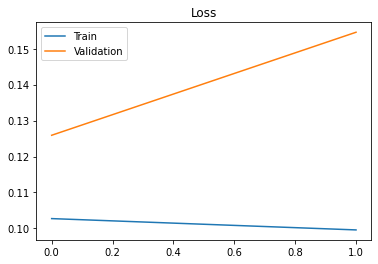

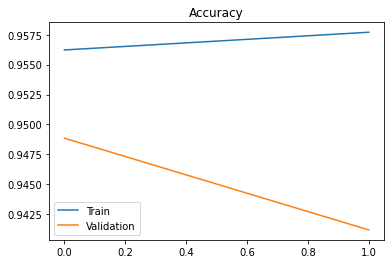

In [207]:
plt.title('Loss')
plt.plot(fit_history.history['loss'], label='Train')
plt.plot(fit_history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(fit_history.history['accuracy'], label='Train')
plt.plot(fit_history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

In [208]:
# Показатель точности обучения
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 1s 14ms/step - loss: 0.1023 - accuracy: 0.9564
Accurracy: 0.9564327001571655


In [209]:
# Получение предсказания и вычисление матрицы путаницы
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 1s 13ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12463,    68],
       [  613,  2487]])

In [210]:
# Вычисление precision и recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9733855185909981 
 recall =  0.802258064516129


#### **теперь рассмотрим работу с тестовыми данными.**

In [211]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [212]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [213]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [214]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [215]:
# Точность тестовых данных
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.1310 - accuracy: 0.9140 - 55ms/epoch - 18ms/step
Accurracy: 0.9139785170555115


In [216]:
# Получение предсказания и вычисление матрицы путаницы
y_pred_test = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[67,  1],
       [ 7, 18]])

In [217]:
# Вычисление precision и recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.9473684210526315 
 Recall:  0.72 
 F1-score: 0.8181818181818181


In [218]:
temp_results = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['RNN'])
results_df = results_df.append(temp_results)
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.967742,0.958333,0.92,0.938776
RNN,0.913979,0.947368,0.72,0.818182


# **GRU**

In [219]:
# Построение нейросети, добавление слоев
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(GRU(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

GRU() - управляемые рекурентные блоки, механижм для рекуррентных нейронных сетей

In [220]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 50, 100)           38100     
                                                                 
 dropout_16 (Dropout)        (None, 50, 100)           0         
                                                                 
 gru_5 (GRU)                 (None, 50)                22800     
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 60,951
Trainable params: 60,951
Non-trainable params: 0
_________________________________________________________________
None


Определение числа параметров Param в каждом слое:

---
Для слоев GRU кол-во параметров расчиывается по формуле:

$params = ((input\_size + output\_size) * output\_size + 2 * output\_size) * bias$

Согласно этому для gru получаем:
$params = ((25 + 100) * 100 + 2 * 100) * 3 = 38100$

Для gru_1:
$params = ((100 + 50) * 50 + 2 * 50) * 3 = 22800$


# **Обучение на CPU**

In [221]:
gru_cpu_time = time.time()
# fit the network
fit_history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
gru_cpu_time = time.time() - gru_cpu_time

Epoch 1/10
75/75 [==============================] - 8s 52ms/step - loss: 0.2439 - accuracy: 0.8964 - val_loss: 0.1590 - val_accuracy: 0.9322
Epoch 2/10
75/75 [==============================] - 2s 33ms/step - loss: 0.1348 - accuracy: 0.9422 - val_loss: 0.1386 - val_accuracy: 0.9425


In [222]:
gru_cpu_time
#34.848602294921875

10.071008920669556

# **Обучение на GPU**

In [223]:
gru_gpu_time = time.time()
# fit the network
fit_history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
gru_gpu_time = time.time() - gru_gpu_time

Epoch 1/10
75/75 [==============================] - 3s 33ms/step - loss: 0.0990 - accuracy: 0.9580 - val_loss: 0.0807 - val_accuracy: 0.9616
Epoch 2/10
75/75 [==============================] - 2s 33ms/step - loss: 0.0755 - accuracy: 0.9670 - val_loss: 0.0822 - val_accuracy: 0.9629


In [224]:
gru_gpu_time

8.786990404129028

# Графическая зависимость для Loss и Accuracy на Train и Validation подвыборках

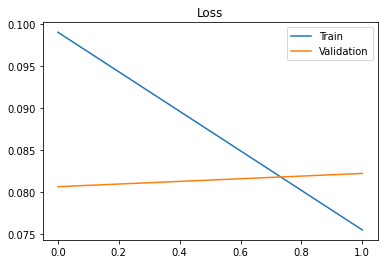

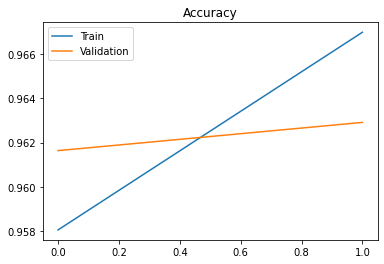

In [225]:
plt.title('Loss')
plt.plot(fit_history.history['loss'], label='Train')
plt.plot(fit_history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(fit_history.history['accuracy'], label='Train')
plt.plot(fit_history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

In [226]:
# Показатель точности обучения
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 1s 13ms/step - loss: 0.0843 - accuracy: 0.9617
Accurracy: 0.9617426991462708


In [227]:
# Получение предсказания и вычисление матрицы путаницы
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 2s 10ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[11960,   571],
       [   27,  3073]])

In [228]:
# Вычисление precision и recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.8433040614709111 
 recall =  0.9912903225806452


#### **теперь рассмотрим работу с тестовыми данными.**

In [229]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [230]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [231]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [232]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [233]:
# Точность тестовых данных
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0565 - accuracy: 0.9785 - 47ms/epoch - 16ms/step
Accurracy: 0.9784946441650391


In [234]:
# Получение предсказания и вычисление матрицы путаницы
y_pred_test = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[66,  2],
       [ 0, 25]])

In [235]:
# Вычисление precision и recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.9259259259259259 
 Recall:  1.0 
 F1-score: 0.9615384615384615


In [236]:
temp_results = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['GRU'])
results_df = results_df.append(temp_results)
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.967742,0.958333,0.92,0.938776
RNN,0.913979,0.947368,0.72,0.818182
GRU,0.978495,0.925926,1.00,0.961538


Оценка времени обучения на CPU и GPU для разных методов

<BarContainer object of 6 artists>

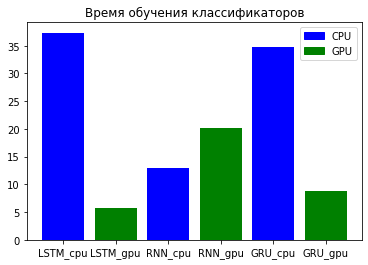

In [237]:
compare_data = [37.31594181060791, lstm_gpu_time, 12.886520624160767, rnn_gpu_time, 34.848602294921875, gru_gpu_time]
axis = ['LSTM_cpu', 'LSTM_gpu', 'RNN_cpu', 'RNN_gpu', 'GRU_cpu', 'GRU_gpu']
plt.title("Время обучения классификаторов")
colors = {'CPU':'blue', 'GPU':'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.bar(axis, compare_data, color=['blue', 'green', 'blue', 'green', 'blue', 'green',])

# **Выводы**

---

Использование GPU при обучении классификаторов дает многократный прирост скорости, однако это не подходит для RNN модели.

Было проведено обучение для набора данных с id = 13

*   По метрике Accuracy GRU классификатор оказался точнее
*   По метрике Precision LSTM классификатор оказался лучшим
*   По метрикам Recall и F1-measure эффективнее всех себя показал GRU классификатор

Исходя из метрик, мы можем сделать вывод, что для набора данных с id 13 классификатор c использованием GRU слоев оказался наилучшим.

Для Seed = 33


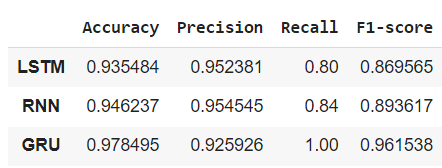

Для Seed = 0

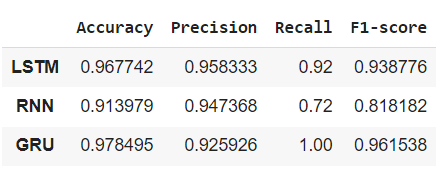

Хоть измененение seed и влияет на результаты обучения, GRU классификатор остается лучшим